#  Эмбеддинги и информационный поиск

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://rusvectores.org/
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* https://github.com/natasha/navec
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

## Задачи для совместного разбора

1\. Создайте объект `nn.Embedding` на основе файла `sample.vec`.

In [194]:
import torch as th

In [195]:
embeddings = []
index = {}
with open("data/sample.vec") as fp:
  fp.readline()
  for idx, line in enumerate(fp):
    word, *v = line.split(" ")
    v = [float(x) for x in v]
    embeddings.append(v)
    index[word] = idx

embeddings = th.tensor(embeddings)


In [196]:
embeddings

tensor([[-0.0312,  0.0243, -0.0314,  ..., -0.0880,  0.0217, -0.0011],
        [-0.0091,  0.0305,  0.0016,  ..., -0.0671,  0.0900,  0.0647],
        [ 0.0092,  0.0413,  0.0039,  ..., -0.0028,  0.0904,  0.0656],
        [-0.0611,  0.0601,  0.0791,  ..., -0.0239,  0.0646,  0.0744]])

In [197]:
import torch.nn as nn

emb = nn.Embedding(num_embeddings=4, embedding_dim=300)
emb.weight

Parameter containing:
tensor([[ 2.1716,  0.1675, -0.7298,  ...,  0.1379, -1.4870,  0.9178],
        [ 0.3283, -1.4808,  0.0336,  ..., -0.6257, -0.0230, -0.3520],
        [ 0.6210, -0.2985,  1.6830,  ...,  2.4816, -1.2582, -0.0574],
        [-0.5326, -0.1541, -2.4673,  ...,  1.1546,  0.1203,  0.6745]],
       requires_grad=True)

In [198]:
emb_pretrained = nn.Embedding.from_pretrained(embeddings)
emb_pretrained.weight

Parameter containing:
tensor([[-0.0312,  0.0243, -0.0314,  ..., -0.0880,  0.0217, -0.0011],
        [-0.0091,  0.0305,  0.0016,  ..., -0.0671,  0.0900,  0.0647],
        [ 0.0092,  0.0413,  0.0039,  ..., -0.0028,  0.0904,  0.0656],
        [-0.0611,  0.0601,  0.0791,  ..., -0.0239,  0.0646,  0.0744]])

## Задачи для самостоятельного решения

In [199]:
import pymorphy3
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize

<p class="task" id="1"></p>

1\. Воспользовавшись предобученными эмбеддингами (файл `ruscorpora_upos_skipgram_300_5_2018_processed.vec`), создайте словарь, где ключом является слово, а значением - номер строки этого слова в файле эмбеддингами (первую строку при расчете номера строк не учитывайте). Выведите на экран количество элементов в словаре. Создайте двумерный массив эмбеддингов и выведите на экран его форму.

- [x] Проверено на семинаре

In [200]:
embeddings = []
index = {}
with open("data/ruscorpora_upos_skipgram_300_5_2018_processed.vec", encoding='utf-8') as fp:
  fp.readline()
  for idx, line in enumerate(fp):
    word, *v = line.split(" ")
    v = [float(x) for x in v]
    embeddings.append(v)
    index[word] = idx

embeddings = th.tensor(embeddings)

print(len(index))
embeddings.shape

160494


torch.Size([160494, 300])

<p class="task" id="2"></p>

2\. Используя PCA, уменьшите размерность загруженных эмбеддингов до 2. Визуализируйте на плоскости точки для слов "кот", "кошка", "собака", "киса", "овчарка", "студент", "препод". Добавьте для точек подписи. Оцените, образуют ли они смысловые кластеры.

- [x] Проверено на семинаре

In [201]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
embeddings_pca.shape

(160494, 2)

кот [-0.27172231 -0.10805199]
кошка [-0.20595619 -0.17779004]
собака [-0.21387276 -0.12030928]
киса [-0.2456235  -0.04240859]
овчарка [-0.12504547 -0.14756879]
студент [0.03927993 0.12680043]
препод [-0.02845174  0.14375378]


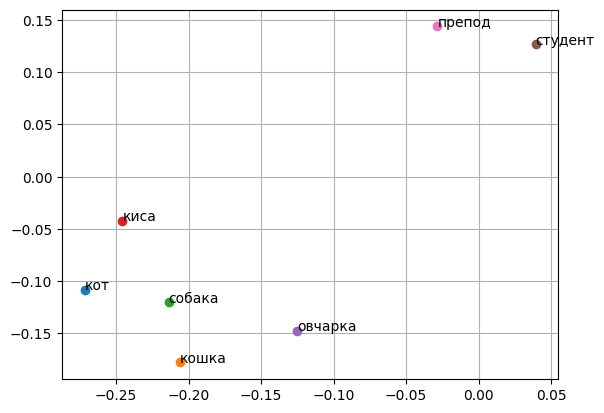

In [202]:
import matplotlib.pyplot as plt

for word in ["кот", "кошка", "собака", "киса", "овчарка", "студент", "препод"]:
    print(word, embeddings_pca[index[word]])
    plt.plot(embeddings_pca[index[word]][0],embeddings_pca[index[word]][1], 'o')
    plt.annotate(word, embeddings_pca[index[word]])
plt.grid(True)
plt.show()

Студент ближе к преподу, чем к овчарке, так что да. Образуют

<p class="task" id="3"></p>

3\. Создайте слой `nn.Embedding` на основе загруженных эмбеддингов. Для каждого слова из задания 2 найдите соответствующий ему индекс. Используя найденные индексы, получите для каждого слова его векторное представление. Добавьте обработку специальных токенов:
* Индекс 0 - `<PAD>` - вектор из нулей.
* Индекс 1 — `<UNK>` - среднее значение всех векторов.

Для того, чтобы это сделать, вам необходимо расширить массив эмбеддингов сверху и учесть сдвиг между номерами строк в массиве и индексами токенов.

Выведите форму полученного тензора.

- [x] Проверено на семинаре

In [203]:
V_PAD = th.zeros(300)
V_PAD.shape

torch.Size([300])

In [204]:
V_UNK = th.mean(embeddings, dim=0)
V_UNK.shape

torch.Size([300])

In [205]:
embeddings_ = th.stack((V_PAD,V_UNK, *embeddings))
embeddings_.shape

torch.Size([160496, 300])

In [206]:
index = {key: value+2 for key,value in index.items()}
index['<PAD>'] = 0
index['<UNK>'] = 1

In [207]:
emb = nn.Embedding.from_pretrained(embeddings_, freeze=True)
emb

Embedding(160496, 300)

In [208]:
indices = th.tensor([index[word] for word in ["кот", "кошка", "собака", "киса", "овчарка", "студент", "препод"]])
emb(indices).shape

torch.Size([7, 300])

<p class="task" id="4"></p>

4\. Реализуйте функцию `get_sentence_vector`, которая строит вектор для предложения.
Для каждого слова в каждом предложении батча получите его индекс. При поиске индекса слова приводите слово к нормальной форме. В случае отсутствия слова в словаре используйте индекс токена `<UNK>`. Дополните все наборы индексов до одного размера индексом токена `<PAD>`. Используя найденные индексы, получите для каждого слова в каждом предложении его векторное представление. Выведите форму полученного тензора.

Получите векторное представление каждого предложения путем усреднения эмбеддингов слов этого предложения. Выведите форму результата на экран.

- [x] Проверено на семинаре

In [209]:
sents = [
    "робот пылесос только что опередил меня и сожрал попкорнину которую я хотел поднять",
    "я приходил к хирургу он мне предложил отрезать ухо"
]

In [210]:
def get_sentence_vector(sents, padding=15):
    morph = pymorphy3.MorphAnalyzer()
    ans = []
    for sent in sents:
            
        sent_norm = []
        for word in word_tokenize(sent):
            parsed = morph.parse(word)[0]
            sent_norm.append(parsed.normal_form)
            
        indices = np.array([index.get(word,1) for word in sent_norm])
        padded = np.zeros((padding))
        padded[:indices.shape[0]] = indices[:padding]
        ans.append(emb(th.tensor(padded,dtype=th.int64)).mean(dim=0))
    return th.stack(ans)
    
get_sentence_vector(sents).shape

torch.Size([2, 300])

In [211]:
get_sentence_vector(sents)

tensor([[-6.5545e-03, -9.8134e-03,  2.5183e-02, -1.9949e-02,  4.0910e-02,
          1.6670e-02,  2.4380e-03, -2.1147e-03, -4.5833e-03, -6.8714e-03,
         -1.5775e-02, -3.7649e-02, -1.4518e-02, -1.0734e-02,  2.1202e-02,
         -3.6696e-02, -2.6461e-02, -1.8794e-02, -6.1420e-02, -4.3015e-02,
          2.9579e-02, -3.5665e-02,  3.5910e-03,  3.3461e-02, -1.7760e-02,
         -2.4274e-02,  2.4149e-02, -2.9738e-02,  1.3391e-02, -3.9771e-02,
          1.2222e-02,  9.6012e-03, -2.3912e-02,  1.9004e-02, -9.4425e-03,
          3.6535e-02,  2.7142e-03, -3.4814e-02, -3.6939e-03, -8.5229e-03,
          3.4356e-02, -1.8173e-03, -1.1118e-03, -9.6242e-03,  2.7070e-02,
         -2.5660e-02, -1.7889e-02, -2.7157e-02,  1.7353e-02, -4.4896e-02,
         -1.5765e-03,  1.1633e-02,  1.1407e-02,  1.4159e-02, -3.1000e-02,
         -1.2196e-02,  2.6375e-02,  1.7731e-02, -1.2304e-02,  5.8620e-03,
         -6.2816e-04,  1.6572e-02,  4.5792e-03, -9.1392e-03, -4.5672e-02,
         -4.3999e-02, -6.2540e-03,  9.

<p class="task" id="5"></p>

5\. Получите эмбеддингами каждого из заголовков новостей из файла `news_500.csv`. Сохраните результат в виде двумерного тензора.
Напишите функцию `search_emb(query, n)`, которая векторизует запрос `query`, считает косинусное сходство между между запросом и эмбеддингом каждого из заголовков, и возвращает топ-n самых похожих заголовков. Продемонстрируйте работу на примерах.

- [ ] Проверено на семинаре

In [212]:
news_embs=[]
title2index = {}
index2title = {}
for idx, title in enumerate(pd.read_csv("data/news_500.csv")['title'].values):
    news_embs.append(get_sentence_vector([title]).tolist())
    title2index[title] = idx
    index2title[idx] = title

    
news_embs = th.tensor(news_embs)

In [213]:
news_embs

tensor([[[-0.0033,  0.0053,  0.0225,  ..., -0.0145,  0.0037, -0.0058]],

        [[-0.0027, -0.0096,  0.0127,  ..., -0.0079,  0.0198,  0.0056]],

        [[-0.0054,  0.0035,  0.0018,  ..., -0.0116, -0.0109, -0.0047]],

        ...,

        [[ 0.0001,  0.0068,  0.0255,  ..., -0.0139,  0.0153,  0.0065]],

        [[ 0.0001,  0.0068,  0.0255,  ..., -0.0139,  0.0153,  0.0065]],

        [[-0.0145,  0.0038,  0.0230,  ..., -0.0001,  0.0011,  0.0084]]])

In [214]:
def search_emb(querry, n):
    q_emb = get_sentence_vector([querry])
    
    cos_sims = []
    for i in news_embs:
        cos_sims.append(nn.functional.cosine_similarity(q_emb, i, dim=1).tolist()[0])
    sorted_indices = np.argsort(cos_sims)
    return [index2title[i] for i in sorted_indices[-n:][::-1]]


In [215]:
search_emb(sents[0], 5)

['Буш и Путин «прибыли», но «прорыва» от них не ждут',
 'Борис Федоров копает под "Газпром" и "Итеру"',
 'Наших моряков с танкера «Вирго», наконец, освободили',
 'НТВ не хочет платить «Медиа-Мосту» 130 миллионов',
 'Горбачев: Жириновский, не разыгрывайте из себя дурака!']

In [216]:
search_emb(sents[1], 5)

['Горбачев: Жириновский, не разыгрывайте из себя дурака!',
 'Наших моряков с танкера «Вирго», наконец, освободили',
 '«Единство» решило пока не снимать Селезнева',
 'Буш и Путин «прибыли», но «прорыва» от них не ждут',
 'Кто греет руки на жилье для офицеров?']

<p class="task" id="6"></p>

6\. Обучите модель `TfIdfVectorizer` на заголовках новостей из файла `news_500.csv`. Получите векторные представления каждого из заголовков при помощи этой модели.

Напишите функцию `search_tfidf(query, n)`, которая векторизует запрос `query`, считает косинусное сходство между между запросом и векторным представлением каждого из заголовков, и возвращает топ-n самых похожих заголовков. Продемонстрируйте работу на примерах.

- [ ] Проверено на семинаре

In [217]:
model = TfidfVectorizer()
news = model.fit_transform(pd.read_csv("data/news_500.csv")['title'].values)
news_tfidf = news.toarray()
news_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(500, 1447))

In [218]:
def search_tfidf(querry, n):
    vector_q = th.tensor(model.transform([querry]).toarray()).squeeze()
    cos_sims = []
    for i in news_tfidf:
        cos_sims.append(nn.functional.cosine_similarity(vector_q, th.tensor(i).squeeze(), dim=0))
        # print(cos_sims[-1])
        # break
    sorted_indices = np.argsort(cos_sims)
    return [index2title[i] for i in sorted_indices[-n:][::-1]]
    



In [219]:
search_tfidf(sents[0], 5)

['Теракты в США – только начало?',
 'Теракты в США – только начало?',
 'Война может поднять интерес инвесторов к России',
 'Война может поднять интерес инвесторов к России',
 'Что ожидает мировой рынок?']

In [220]:
search_tfidf(sents[1], 5)

['В.Путин торопит разработчиков военной реформы',
 'Депутаты Госдумы займутся офшорными банками',
 'Российские законы усовершенствуют для вступления в ВТО',
 'Российские законы усовершенствуют для вступления в ВТО',
 'Российские райцентры уже без света']

Новости повторяются, так как они таковы, каковы нам даны в `news500`

<p class="task" id="7"></p>

7\. Сравните работу двух функций для поиска на следующих типах запросов (подберите запросы так, чтобы увидеть разницу):

1. запрос содержит редкие слова, которые есть в базе (например, фамилии, названия компаний).
2. запрос не содержит общих слов с заголовком, но близок по смыслу.
3. запрос содержит опечатки.

Напишите краткий вывод по результатам.

- [ ] Проверено на семинаре

1. Запрос содержит редкие слова (имена, названия).<br>
Ожидаем найти новость про Газпром и Итеру

In [221]:
query_rare = "Газпром и Итера"

print("TF-IDF:", search_tfidf(query_rare, 3))
print("Embeddings:", search_emb(query_rare, 3))

TF-IDF: ['Кох намерен скупить активы «Газпром-Медиа»', 'Кох намерен скупить активы «Газпром-Медиа»', 'Борис Федоров копает под "Газпром" и "Итеру"']
Embeddings: ['"Медиа-Мост" не должен "Газпрому"', 'Борис Федоров копает под "Газпром" и "Итеру"', '"Роснефть" будет добывать нефть в Чечне']


2. Запрос не содержит общих слов, но близок по смыслу<br>
Целимся в новость 'Теракты в США – только начало?'

In [222]:
query_semantic = "взрывы в америке будут продолжаться"

print("TF-IDF:", search_tfidf(query_semantic, 3))
print("Embeddings:", search_emb(query_semantic, 3))


TF-IDF: ['Лукашенко будут переизбирать 9 сентября', 'Криминальные доходы будут легализованы?', 'Арафат и Барак будут договариваться']
Embeddings: ['Теракты в США – только начало?', 'Теракты в США – только начало?', 'Самолету США не дали пролететь над Россией']



3. Запрос содержит опечатки<br>
Целимся в новость 'Депутаты Госдумы займутся офшорными банками'

In [227]:

query_typo = "деуптаты гасдумы займуса"

print("TF-IDF:", search_tfidf(query_typo, 3))
print("Embeddings:", search_emb(query_typo, 3))

TF-IDF: ['В.Путин торопит разработчиков военной реформы', 'Депутаты Госдумы займутся офшорными банками', 'Российские законы усовершенствуют для вступления в ВТО']
Embeddings: ['Борис Федоров копает под "Газпром" и "Итеру"', 'Котенков: Кодзоеву надо было сидеть в Госдуме', 'Генпрокуратура «поселилась» в «Медиа-Мосте»']


TF-IDF ограничен размерами датасета, так что для него невстречающиеся слова сложны к поиску. Эмбеддинги хуже справляются с опечатками.